# XY Model Using Normalising Flows

## Importing all needed packages, checking CUDA and setting matplotlib

In [ ]:
# Un-comment the line below if this is the first time using PyTorch.
# !pip install torch

### Import packages

In [ ]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Should always run in 'cpu' if using Jupyter Notebook - GPU support not native.
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_device(torch.cuda.FloatTensor);
    # torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    # torch.set_default_dtype(torch.DoubleTensor)
    torch.set_default_tensor_type(torch.DoubleTensor);
print(f"TORCH DEVICE: {torch_device}")

TORCH VERSION: 2.4.0+cu121
TORCH DEVICE: cpu


### Modding over $2 \pi$ and wrapping

In [ ]:
def torch_mod(x):
    """Mod function for using torch"""
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    """Wraps the tensor"""
    return torch_mod(x+np.pi) - np.pi

### Grab from torch tensor and send to numpy array

In [ ]:
def grab(var):
    """Pulls a variable from a torch tensor module to a numpy array - useful for plotting."""
    return var.detach().cpu().numpy()

### Plotting tools

In [ ]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
    """Define a 'live' plot to plot effective sample size and loss function against number of iterations."""
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)

    ess_line = plt.plot([0],[0], alpha=0.5, c = 'black') # dummy
    plt.grid(False)
    plt.ylabel('ESS (black line)')

    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss (orange line)')

    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    """Sets the limits for the moving trendline window size."""
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    """Dynamically updates the plots to generate a moving trendline."""
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

### Lattice Configuration (XY model)

In [ ]:
L = 6 # Lattice size
lattice_shape = (L,L) # lattice dimensions
xy_phi1 = 2 * np.pi * np.random.random(size=lattice_shape).astype(float_dtype) # first random config
xy_phi2 = 2 * np.pi * np.random.random(size=lattice_shape).astype(float_dtype) # second random config


# Converts from numpy array to a torch tensor for use in PyTorch functions
cfgs = torch.from_numpy(np.stack((xy_phi1, xy_phi2), axis=0)).to(torch_device)

### Angle Difference in XY model - WORKING FINE

In [ ]:
def compute_xy_angle_diff(lattice_shape, shift, mu):
    """Take in tensor of configuration of spin angle values, find difference between values at each lattice return this value"""
    return (
        lattice_shape - torch.roll(lattice_shape, shift, mu)
    )

### Keeping track of correlation data history (how well the new distribution models the desired output)

In [ ]:
corr_data = {
    'new_vals' : []
}

### Action Calculation (XY model)

In [ ]:
class xy_action:
    """This is a class to calculate the action for the configuration of input tensor. It takes in set of configurations, calculates action of given configuration from XY model and spits out tuple of action values, one for each configuration."""
    def __init__(self, J, beta):
        self.J = J
        self.beta = beta
    def __call__(self, cfgs):
        """Calculate across the dimensions, allocate the shift to be used in calculating torch.roll"""
        Nd = 2 # set the number of dimensions
        action_density = 0 # preallocate action
        for mu in range(Nd): # Calculate each dimension separately
            for shift in (-1,+1):
                action_density += torch.cos(compute_xy_angle_diff(cfgs, shift, mu))
        return -self.J * self.beta * torch.sum(action_density, dim=tuple(range(1, Nd+1))) # stores action for each phi separately

xyAction = xy_action(J=1, beta = 1.00) # relabeling to save typing so much and setting value of J - analytical value of J/T = .25, adjusting beta to match at phase transition

# Simple check of action density
xnew = 2 * np.pi * np.zeros(shape=lattice_shape).astype(float_dtype)
ynew = 2 * np.pi * np.zeros(shape=lattice_shape).astype(float_dtype)
xnew[3,2] += np.pi
ynew[2,3] += np.pi

# New test configuration using the given parameters
newcfgs = torch.from_numpy(np.stack((xnew,ynew),axis=0)).to(torch_device)

# Check the configuration was applied properly to each entry
# print(newcfgs[:,:,:])
# xyAction(newcfgs)
# print('Test action for test configuration, ', xyAction(newcfgs))

print('Action for XY configuration, ', xyAction(cfgs))

Action for XY configuration,  tensor([-4.2556,  1.2417])


Check that the action calculation in the XY model is working properly by inserting some known configuration (all zeros except for one entry, call it $\pi$). This way we know the energy at each site should be something like
\begin{equation}
E_i = - 4J\ \cos(0 - 0)\vert_{J=1} = -4
\end{equation} apart from where $\theta = \pi$,
\begin{equation}
E_i = - 4J\ \cos(\pi - 0)\vert_{J=1} = +4
\end{equation}
and the surrounding sites of $\theta = \pi$,
\begin{equation}
E_i = - 4J\ \cos(0 - \pi)\vert_{J=1} = -2
\end{equation}
where the factor of $4$ comes from summing over the differences in
\begin{equation}
S = - J \ \sum_{\langle i,j\rangle} \cos(\theta_i - \theta_j)
\end{equation} such that if the configuration has but one non-zero entry then summing over the nearest neigbours gives a factor of $4$.

The total action for such configuration should be
\begin{equation}
S = - J \ \sum_{\langle i,j\rangle} \cos(\theta_i - \theta_j)|_{J=1} = -240
\end{equation} for an $8 \times 8$ lattice where $J = 1$. Two configurations of the same structure should then give something like `tensor([-240., -240.])`

<!-- The action is working fine because if we just took the *action_density* it would give a tensor of a bunch of $-4$'s, corresponding
to $\sum_{\langle i,j\rangle} \cos(0)$ over all neighbouring sites giving $\sum_{nearest\ neighbours} \cos(0) = 4$. then $\times -J$ to get $-4$ for every site where there is a $0$ surrounded by four other zeros.

Thus THIS action will give $+4$ not $-4$. A difference of $+8$. The remaining differing sites will be the four surrounding $\pi$, which each give $-2$ as one of each of their sites gives a difference of $+1$ so in total $= -2$.
Finally, summing over all the sites will be given by $-4 *$ lattice_size $= -4 * 8 * 8$. Then add to this the $+8$ from the $\pi$ site and $+2$ from each of its surrounding sites $\rightarrow -(4*8*8) + 8 + 8 = -240$. Which is what was given by the test function. -->

### Checking Angular Invariance
The action should be invariant over shifts in the angle. Checking this is simple and should give back the same action regardless of values.

In [ ]:
def angle_transform(lattice_shape, f):
    """Computes an O(2) transformation shifting all values by some amount of pi to check if the action is invariant."""
    new_lattice = lattice_shape.clone()
    for mu in range(2):
        new_lattice += f * np.pi
    return new_lattice

xyAction(cfgs)
f = np.random.random()
cfgs_transf = angle_transform(cfgs, f)

print('The action is invariant: \n', xyAction(cfgs), 'vs', xyAction(cfgs_transf))

The action is invariant: 
 tensor([-4.2556,  1.2417]) vs tensor([-4.2556,  1.2417])


### Multivariate Uniform Distribution

In [ ]:
class MultivariateUniform(torch.nn.Module):
    """Uniformly draw samples from some input range [a,b]."""
    def __init__(self, a, b):
        super().__init__()
        self.dist = torch.distributions.uniform.Uniform(a, b)
    def log_prob(self, x):
        """Computes the log of the probability distribution."""
        axes = range(1, len(x.shape))
        return torch.sum(self.dist.log_prob(x), dim=tuple(axes))
    def sample_n(self, batch_size):
        """Generates a sample from the distribution of the given batch size."""
        return self.dist.sample((batch_size,))

### Prior distribution for XY Model

z.shape = (1028, 6, 6)


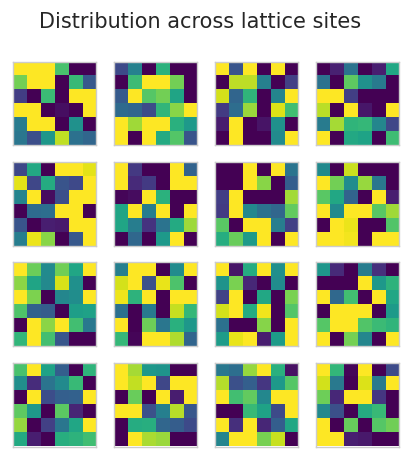

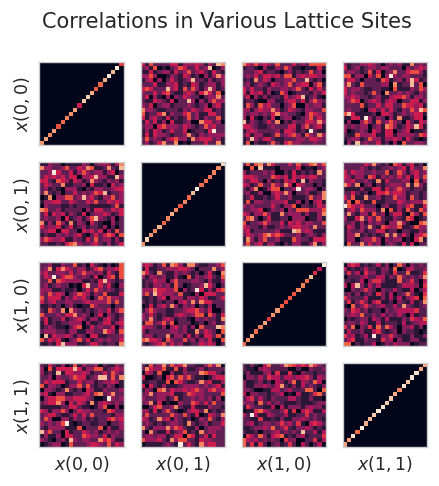

In [ ]:
prior = MultivariateUniform(torch.zeros(lattice_shape), 2 * np.pi * torch.ones(lattice_shape))

# Initialising prior distribution
torch_z = prior.sample_n(1028)
z = grab(torch_z)
print(f'z.shape = {z.shape}')

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tan(z[ind]), vmin=-1, vmax=1, cmap='viridis') # chose tan instead of tanh as this gave a uniform dist.
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
fig.suptitle("Distribution across lattice sites")
plt.show()

# Correlation between lattice sites
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[0,2* np.pi],[0,2* np.pi]], bins=20) # changed range from [[-3,3],[-3,3]]
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])
                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$x({x2},{y2})$')
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$x({x1},{y1})$')
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

The distribution at sites will be different from that of the normal distribution given by the $\phi^4$ model, since the distribution is not a gaussian, but a uniform distribution.

### Comparing Action before applying normalising flow (XY model)

slope 1 linear regression S = -logr + -65.3863


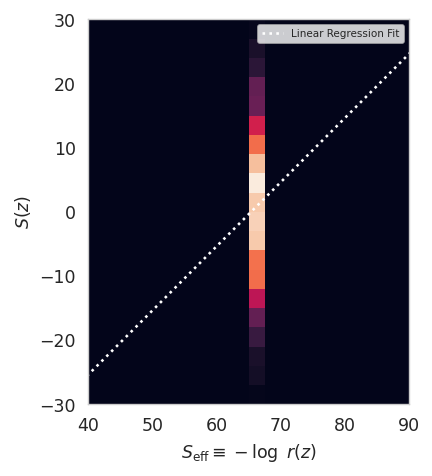

In [ ]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(xyAction(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[40, 90], [-30,30]])
xs = np.linspace(-500, 500, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='Linear Regression Fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
ax.set_ylabel(r'$S(z)$')
ax.set_aspect('equal')
plt.title('')
plt.legend(prop={'size': 6})
plt.show()

### Masking Layers (chequerboard)

In [ ]:
def make_checker_mask(shape, parity):
    """Generates a chequerboard masking for each coupling layer"""
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

print("For example this is the mask for an 8x8 configuration:\n",
      make_checker_mask(lattice_shape, 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


Notice that the mask above only gives a mask for the lattice_shape given, we will check later on that this will work for both lattice input configurations (that is, cfgs[0] *and* cfgs[1]).

### Coupling Layer (XY model)

We wish to transform the variables before defining the coupling layer by computing a simple transformation as follows

\begin{equation}
x\longmapsto x' = 2 \tan^{-1}\left( e^s \tan\left(\frac{x}{2}\right)\right)
\end{equation}

such that the domain of $x$ transforms from an angular variable ranging from $x = [0,2\pi)$ to $x = (-\infty, \infty)$. This way we can continue to use the neural network as defined in the $\phi^4$ model.

The Jacobian is then as follows:
\begin{equation}
J(x) = \left[ e^{-s} \cos^2 \left(\frac{x}{2}\right)  + e^s \sin^2 \left(\frac{x}{2}\right) \right]^{-1}.
\end{equation}

### Initialise weights (not used if setting weights to zero and training properly)

In [ ]:
def set_weights(m):
    """Pre-set weights for network, only needed if not training own network."""
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)

### Apply flow to prior

In [ ]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size): # prior distribution, coupling layers = xyCoupling, batch_size
    """Apply the normalising flow to the prior distribution"""
    x = prior.sample_n(batch_size) # draw a batch of sample from the simple distribution
    logq = prior.log_prob(x) # draw a sample from this batch
    for layer in coupling_layers:
        x, logJ = layer.forward(x) # perform forward pass of nn
        logq = logq - logJ # calculate logq as the log(r(z)*J^-1) = log(r(z)) + log(J^-1) = log(r(z)) - log(J)
    return x, logq # return the flowed probability, and the f(x)

#### Transformations:

In [ ]:
def tan_transform(x, s): # Transforming x input tensor
    """Compute tan(x/2) transformation on input tensor to transform from angular variables"""
    return torch_mod(2*torch.atan(torch.exp(s)*torch.tan(x/2)))


def tan_transform_logJ(x, s): # Jacobian factor
    """Log of Jacobian transformation of change of variables"""
    return -torch.log(torch.exp(-s)*torch.cos(x/2)**2 + torch.exp(s)*torch.sin(x/2)**2)

In [ ]:
def stack_cos_sin(x):
    """Stacks the input tensor into cos/sin components for ease of calculation"""
    return torch.stack((torch.cos(x), torch.sin(x)), dim=1)

In [ ]:
def mixture_tan_transform(x, s):
    """Averaging over tan transformations of input tensor configuration"""
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.mean(tan_transform(x, s), dim=1, keepdim=True)
def mixture_tan_transform_logJ(x, s):
    """Average over log Jacobian transformations"""
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.logsumexp(tan_transform_logJ(x, s), dim=1) - np.log(s.shape[1])

### Inverting the NCP transformation
This is a numerical inversion, but only used once on the reverse pass, testing on new data - so this isn't the worst issue

In [ ]:
def invert_transform_bisect(y, *, f, tol, max_iter, a=0, b=2*np.pi):
    """Numerical inversion of the coupling layer transformation, only needed for the reverse pass (testing on new data)."""
    min_x = a*torch.ones_like(y)
    max_x = b*torch.ones_like(y)
    min_val = f(min_x)
    max_val = f(max_x)
    with torch.no_grad():
        for i in range(max_iter):
            mid_x = (min_x + max_x) / 2
            mid_val = f(mid_x)
            greater_mask = (y > mid_val).int()
            greater_mask = greater_mask.float()
            err = torch.max(torch.abs(y - mid_val))
            if err < tol: return mid_x
            if torch.all((mid_x == min_x) + (mid_x == max_x)):
                print('WARNING: Reached floating point precision before tolerance '
                    f'(iter {i}, err {err})')
                return mid_x
            min_x = greater_mask*mid_x + (1-greater_mask)*min_x
            min_val = greater_mask*mid_val + (1-greater_mask)*min_val
            max_x = (1-greater_mask)*mid_x + greater_mask*max_x
            max_val = (1-greater_mask)*mid_val + greater_mask*max_val
        print(f'WARNING: Did not converge to tol {tol} in {max_iter} iters! Error was {err}')
        return mid_x

In [ ]:
class xyCoupling(torch.nn.Module):
    """The coupling layer class used for XY model"""
    def __init__(self, net, *, mask_shape, mask_parity):
        """Initialised variables"""
        super().__init__() # pulls global parameters to this
        assert len(mask_shape) == 2, (
            f'NCPPlaqCouplingLayer is implemented only in 2D, '
            f'mask shape {mask_shape} is invalid')
        self.mask = make_checker_mask(mask_shape, mask_parity) # define .mask as function defined above
        self.net = net # define .net as the network defined waaay above

    def forward(self, x): # Convert the input tensor with a transformation defined above
        """Forward pass of the neural network"""
        # Generate copy of input tensor with frozen masking
        x_frozen = self.mask * x
        net_out = self.net(stack_cos_sin(x_frozen)) # has shape tensor([64,2,8,8]) but was ([64,1,8,8]) before unsqueeze
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:, :-1], net_out[:, -1]

        # Generate a second copy of the input tensor with active masking
        x_active = (1 - self.mask) * x
        x_active = x_active.unsqueeze(1)

        # logJ has been transformed using the above transformation
        local_logJ = (1-self.mask) * mixture_tan_transform_logJ(x_active, s)
        axes = tuple(range(1,len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)

        # Pick this one if using stack_sin_cos(x2)
        fx1 = (1-self.mask) * mixture_tan_transform(x_active, s).squeeze(1)
        fx = (1-self.mask) * torch_mod(fx1 + t) + x_frozen

        return fx, logJ

    # def reverse(self, fx):
    #     """Backwards pass of network - only needed if checking samples against test data, not needed for training the model."""
    #     fx_frozen = self.mask * fx
    #     net_out = self.net(fx_frozen.unsqueeze(1))
    #     s, t = net_out[:, :-1], net_out[:, -1]

    #     x1 = torch_mod(self.mask * (fx - t).unsqueeze(1))
    #     transform = lambda x: (1-self.mask) * mixture_tan_transform(x, s)
    #     x1 = invert_transform_bisect(
    #             x1, f=transform, tol=self.inv_prec, max_iter=self.inv_max_iter)
    #     local_logJ = (1-self.mask) * mixture_tan_transform_logJ(x1, s)
    #     axes = tuple(range(1, len(local_logJ.shape)))
    #     logJ = -torch.sum(local_logJ, dim=axes)
    #     x1 = x1.squeeze(1)

    #     x = (
    #         (1 - self.mask) * x1 + fx_frozen
    #     )
    #     return x, logJ

### Convolutional Network (CNN, XY Model)

In [ ]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh, use_softmax):
    """This function generates the convolutional network, using layers of Conv2d and LeakyReLU as the activation function"""
    sizes = [in_channels] + hidden_sizes + [out_channels] # total number of input/output channels and hidden layers combined as array
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0') # prevents being run if torch version not recent enough
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0' # ensures kernel size is not even (for some reason)
    padding_size = (kernel_size // 2) # padding with floor division: 5 // 2 = 2 since 5 / 2 = 2.5 and rounded down = 2.
    net = [] # to store output variables in
    for i in range(len(sizes) - 1): # run from 0 -> len(sizes)-1
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular')) # add outputs to network array
            # sizes[i] implements the ith component as the input channel and sizes[i+1] uses the next one along
        if i != len(sizes) - 2: # while not at last element in the for loop
            net.append(torch.nn.LeakyReLU()) # then add some leaky relu
        elif use_final_tanh:
            # otherwise, use a final non-linear function (tanh or softmax)
            net.append(torch.nn.Tanh())
        else:
            if use_softmax:
                net.append(torch.nn.Softmax(dim=in_channels))
    return torch.nn.Sequential(*net) # unpacks the list of net = [] values and parses through sequential function

### Adding xy coupling layers to conv. network

In [ ]:
def make_xyCoupling_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size): # generating the affine layers for phi-4
    """Generates the coupling layers which evolve the distribution, consisting of neural network defined in make_conv_net and the xyCoupling class."""
    layers = []
    for i in range(n_layers):
        parity = i % 2 # checkerboard parity switches between different sites in lattice
        # parity will apply transformation to only one site then fix the other, and continue this pattern through the lattice
        net = make_conv_net(
        # in_channels=1, out_channels=2, hidden_sizes=hidden_sizes, # Original - keep if NOT STACKING
            in_channels=2, out_channels=3, hidden_sizes=hidden_sizes, # Use if stacking!
            kernel_size=kernel_size, use_final_tanh=False,use_softmax=False) # adding convolutional net
        """Above I have removed the 'use_final_tanh' as this may be screwing up the angular variables"""
        coupling = xyCoupling(net, mask_shape=lattice_shape, mask_parity=parity) # gives it either value of 0 or 1
        layers.append(coupling) # add the coupling to the layers
    return torch.nn.ModuleList(layers) # return a list of the layer values after applying layers

## Training

### Kullback-Leibler divergence minimisation

In [ ]:
def calc_dkl(logp, logq):
    """Kullback-Leibler divergence loss function using log(q) and log(p) where q is the flowed and p the desired distributions."""
    # return (logp - logq).mean() # forward KL assuming samples from q
#     return (2*logp - logq).mean() # alpha divergence
    return (logq - logp).mean()  # reverse KL, assuming samples from q

### Training steps (ESS = effective sample size)

In [ ]:
def train_step(model, action, loss_fn, optimizer, metrics):
    """Performs one training step, by applying the normalising flow to the prior distribution, stores the loss, logq, logp to a library called 'metrics'."""
    layers, prior = model['layers'], model['prior'] # pull various layers and priors from dictionary above
    optimizer.zero_grad(set_to_none=True) # zero the gradients for the nn

    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size) # do generative flow
    logp = -action(x) # find log probability - notice no normalisation constant from partition function
    loss = calc_dkl(logp, logq) # dkl loss step using flowed and desired probability
    loss.backward() # perform backwards step
    optimizer.step() # do forward optimiser step

    # get all variables and add to metrics dictionary
    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

def compute_ess(logp, logq):
    """Computes the effective sample size, which is equivalent to the normalised sum of the difference in probability distributions"""
    logw = logp - logq # compute difference in probabilities for KL divergence
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw) # compute effective sample size per size of configuration tensor (input tensor)
    return ess_per_cfg

def print_metrics(history, avg_last_N_epochs):
    """Prints the various metrics: loss, logq, logp, effective sample size (ess)."""
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

### Perform training steps
#### Setting parameters for training

In [ ]:
# Check whether to use the pretrained network (given in original code)
use_pretrained = False # legacy function, not needed here if training from scratch ~ see Normalizing Flows Albergo, et al. for useage.

L = 6 # dictate size of lattice
lattice_shape = (L,L) # dictates the shape (square in our case)
prior = MultivariateUniform(torch.zeros(lattice_shape), 2 * np.pi * torch.ones(lattice_shape)) # generate prior distribution
n_layers = 8 # total number of coupling layers - was 16, now 8

# Depth of hidden layers (number of input/output channels)
hidden_sizes = [8,8] # size of hidden layers
kernel_size = 3 # self-explanatory

# Create coupling layers to apply to prior
layers = make_xyCoupling_layers(lattice_shape=lattice_shape, n_layers=n_layers,
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
# set_weights(layers) # not needed for training from scratch
model = {'layers': layers, 'prior': prior} # dictionary containing output parameters (layers and respective priors)

# Training
base_lr = .001 # base learning rate
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr) # Attempted with SGD instead of Adam, Adam appears to give best performance.

### Setting # of loops and dictionary of data

In [ ]:
# 1 era is equivalent to a full pass of the network
N_era = 10
# 1 epoch is one iteration of the network
N_epoch = 100 # Can increase to overfit the data and check if training minimizes loss properly. Not recommended to increase otherwise doesn't accurately fit data (performs overfitting).

batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

### Calculating minimisation steps

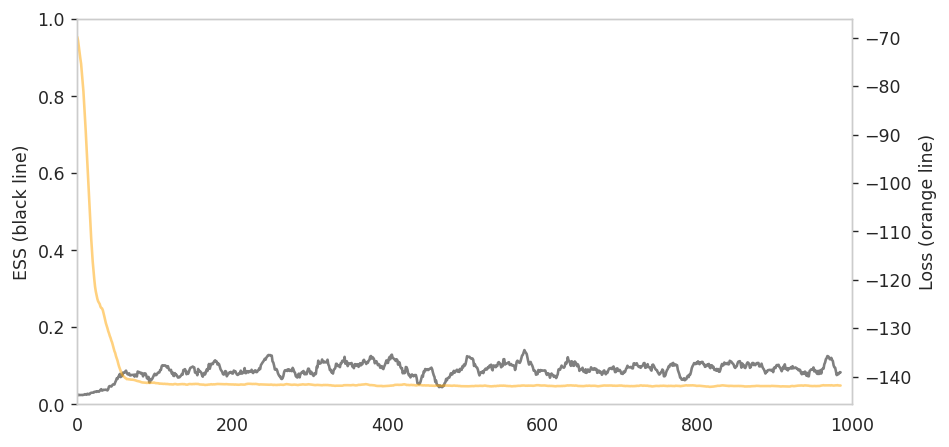

== Era 0 | Epoch 0 metrics ==
	loss -68.0597
	logp 1.89789
	logq -66.1618
	ess 0.0323116
== Era 1 | Epoch 0 metrics ==
	loss -121.587
	logp 93.9089
	logq -27.6783
	ess 0.0523847
== Era 2 | Epoch 0 metrics ==
	loss -141.513
	logp 124.06
	logq -17.453
	ess 0.086079
== Era 3 | Epoch 0 metrics ==
	loss -141.61
	logp 124.097
	logq -17.5133
	ess 0.0898177
== Era 4 | Epoch 0 metrics ==
	loss -141.741
	logp 124.234
	logq -17.5072
	ess 0.101619
== Era 5 | Epoch 0 metrics ==
	loss -141.798
	logp 124.173
	logq -17.6245
	ess 0.0826453
== Era 6 | Epoch 0 metrics ==
	loss -141.899
	logp 124.276
	logq -17.6228
	ess 0.103603
== Era 7 | Epoch 0 metrics ==
	loss -141.875
	logp 124.321
	logq -17.554
	ess 0.0899167
== Era 8 | Epoch 0 metrics ==
	loss -141.878
	logp 124.143
	logq -17.7349
	ess 0.0897761
== Era 9 | Epoch 0 metrics ==
	loss -141.936
	logp 124.358
	logq -17.578
	ess 0.101211


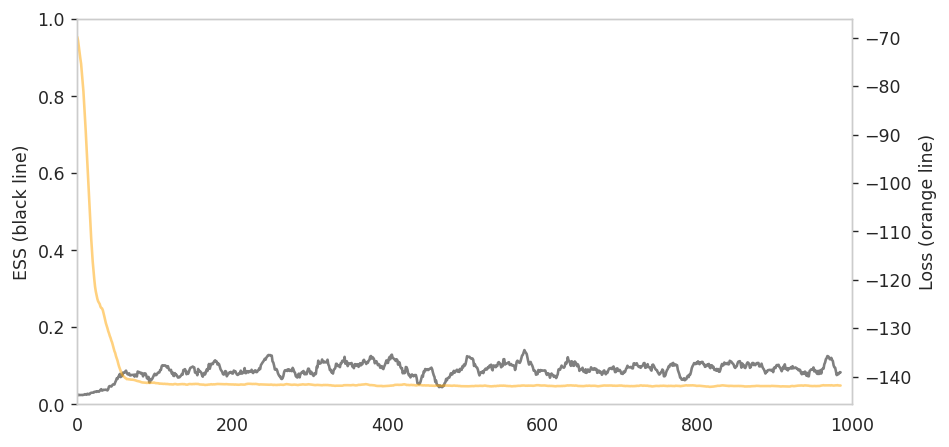

In [ ]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot() # generate live plot

    for era in range(N_era): # Era is bigger than epoch
        for epoch in range(N_epoch): # number of runs through the training data
            train_step(model, xyAction, calc_dkl, optimizer, history) # train the model

            if epoch % print_freq == 0: # if completed one full pass, print below
                print_metrics(history, avg_last_N_epochs=print_freq)

            # Below: if epochs mod 1 == 0 then update the plot (basically this will always update the plot for every iteration)
            if epoch % plot_freq == 0: # epochs mod 1 = 0 for all epochs
                update_plots(history, **live_plot)
else:
    print('Skipping training')

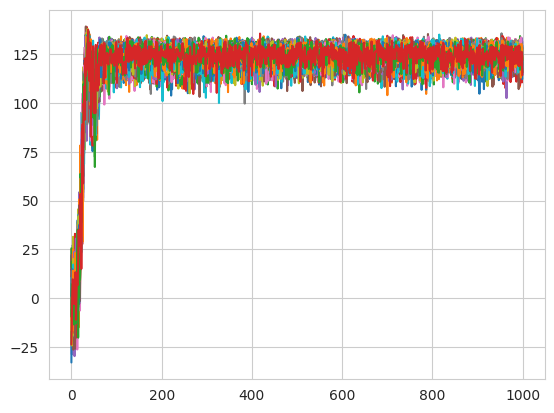

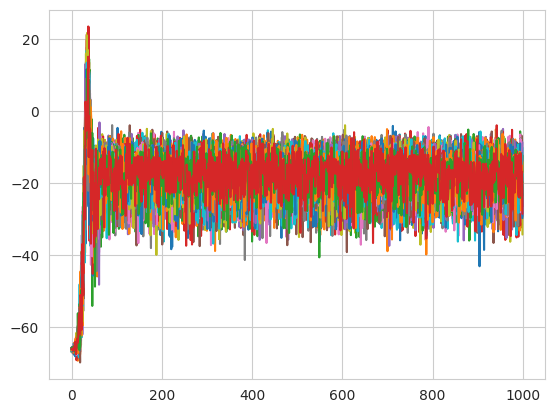

(64,)

In [ ]:
plt.plot(history['logp'])
plt.show()


plt.plot(history['logq'])
plt.show()

history['logp'][0].shape

### Saving weights

In [ ]:
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)

## Evaluating the Model

### Draw samples from the model

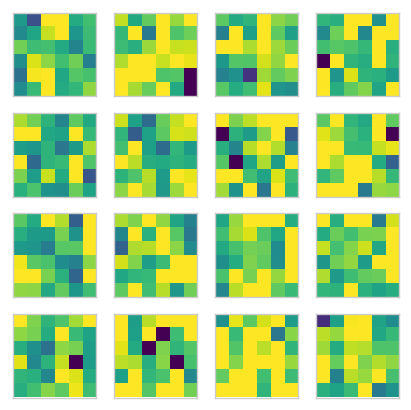

slope 1 linear regression S = S_eff + -141.8632


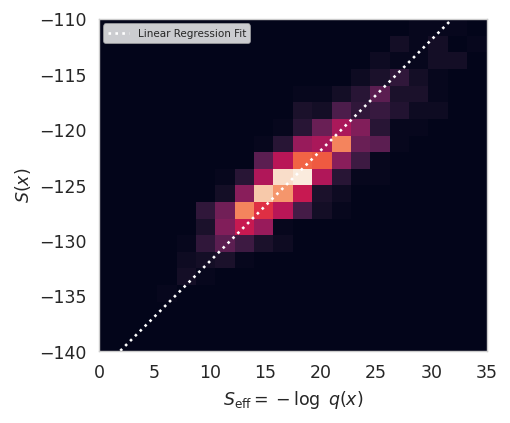

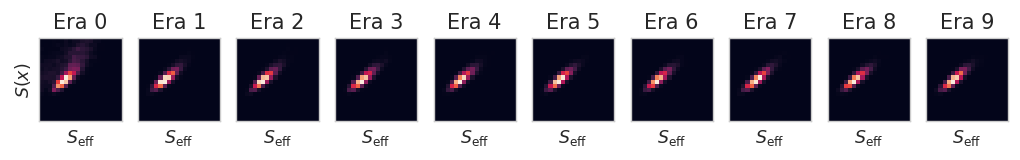

In [ ]:
# Applying the flow to the prior probability distribution and get out the log(q(x)) and x values (the probability and weights)
layers, prior = model['layers'], model['prior']
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4)) # set figure options
for i in range(4): # 4 x 4 figures
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tan(grab(torch_x)[ind]), vmin=-1, vmax=1, cmap='viridis') # applying tanh to x values?
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

S_eff = -grab(torch_logq)
S = grab(xyAction(torch_x))

fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
# ax.hist2d(S_eff, S, bins=20, range=[[-500,500],[-500,500]])
# ax.hist2d(S_eff, S, bins=20, range=[[62,70],[-4,2.5]]) # j = 0.1, best training so far
ax.hist2d(S_eff, S, bins=20, range=[[0,35],[-140,-110]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(-500,500, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='Linear Regression Fit')
plt.legend(prop={'size': 6})
plt.show()

"""Plotting the probability distributions"""
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=False, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[0,50],[-150,-100]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()

### Implementing Metropolis algorithm sampling
#### Generating samples

In [ ]:
def serial_sample_generator(model, action, batch_size, N_samples):
    """Generate samples from the model"""
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

#### Construct Markov chain using Metropolis independence sampler

In [ ]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    """Using Markov-Chain Monte Carlo as an independence sampler to build a chain of random samples from distribution. Uses Hastings algorithm as acceptance condition for random sample drawn from flowed distribution. This is then compared with samples drawn from the desired distribution to determine accuracy."""
    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]

            last_logq = history['logq'][-1]

            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))

            p_accept = min(1, p_accept)

            draw = torch.rand(1) # ~ [0,1]

            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

### Checking acceptance rate of ensemble

In [ ]:
# Create a (relatively) large ensemble size for the number of samples
ensemble_size = 8132
xy_ens = make_mcmc_ensemble(model, xyAction, 64, ensemble_size)
print("Accept rate:", np.mean(xy_ens['accepted']))

# Building library of correlation data to see how this varies as we change parameters
corr_data['new_vals'].append(np.mean(xy_ens['accepted']))

# Count how many samples are rejected/accepted
counter = 0
for i in xy_ens['accepted']:
    if i == False:
        counter += 1

print(f'History of correlation data: {corr_data}')
print(f'{counter} number of samples in batch size not accepted')

Accept rate: 0.04980324643384161
History of correlation data: {'new_vals': [0.04980324643384161]}
7727 number of samples in batch size not accepted
